# Using TensorBoard with PyTorch
## 环境准备

在运行这个实例之前你需要安装 PyTorch, TorchVision, Matplotlib, and TensorBoard.

With `conda`:

`conda install pytorch torchvision -c pytorch`
`conda install matplotlib tensorboard`

With `pip`:

`pip install torch torchvision matplotlib tensorboard`

Once the dependencies are installed, restart this notebook in the Python environment where you installed them.

## 引言

在本笔记中，我们将使用Fashion-MNIST数据集来训练LeNet-5的一种变体。Fashion-MNIST是一组图像瓷砖，描绘了各种衣物，带有十个类别标签，指示所描绘的衣物类型。

In [1]:
# PyTorch model and training necessities
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# Image datasets and image manipulation
import torchvision
import torchvision.transforms as transforms

# Image display
import matplotlib.pyplot as plt
import numpy as np

# PyTorch TensorBoard support
from torch.utils.tensorboard import SummaryWriter

## 一、在TensorBoard中显示图像

我们从将数据集中的样本图像添加到TensorBoard开始：

In [2]:
# Gather datasets and prepare them for consumption
transform = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))])

# Store separate training and validations splits in ./data
training_set = torchvision.datasets.FashionMNIST('./data',
    download=True,
    train=True,
    transform=transform)
validation_set = torchvision.datasets.FashionMNIST('./data',
    download=True,
    train=False,
    transform=transform)

training_loader = torch.utils.data.DataLoader(training_set,
                                              batch_size=4,
                                              shuffle=True,
                                              num_workers=2)


validation_loader = torch.utils.data.DataLoader(validation_set,
                                                batch_size=4,
                                                shuffle=False,
                                                num_workers=2)

# Class labels
classes = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
        'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot')

In [3]:
# Helper function for inline image display
def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

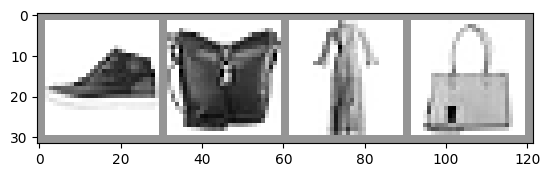

In [4]:
# Extract a batch of 4 images
images, labels = next(iter(training_loader))

# Create a grid from the images and show them
img_grid = torchvision.utils.make_grid(images)
matplotlib_imshow(img_grid, one_channel=True)

In [5]:
# 实例化，输入存储的路径
writer = SummaryWriter('runs/fashion_mnist_experiment_3')


# 将img_grid添加到里面
writer.add_image('Four Fashion-MNIST Images', img_grid)
writer.flush()

%load_ext tensorboard
%tensorboard --logdir runs/fashion_mnist_experiment_3

# To view, start TensorBoard on the command line with:
#   tensorboard --logdir=runs
# ...and open a browser tab to http://localhost:6006/



如果你在命令行启动TensorBoard，并在新的浏览器标签页中打开它（通常位于[localhost:6006]），你应该能在IMAGES标签下看到图像网格。

## 二、用标量绘图以可视化训练和显示模型中权重和梯度变化

TensorBoard对于追踪你的训练进度和效果非常有用。下面，我们将运行一个训练循环，跟踪一些指标，并保存供TensorBoard使用的数据。

让我们定义一个模型来对我们的图像瓷砖进行分类，以及用于训练的优化器和损失函数：

In [6]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    

net = Net()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

下面用定义好的网络训练一轮，看下训练损失和验证损失

In [7]:
print(len(validation_loader))
for epoch in range(1):  # loop over the dataset multiple times
    running_loss = 0.0

    for i, data in enumerate(training_loader, 0):
        # basic training loop
        inputs, labels = data
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 1000 == 999:    # Every 1000 mini-batches...
            print('Batch {}'.format(i + 1))
            # Check against the validation set
            running_vloss = 0.0
            
            net.train(False) # Don't need to track gradents for validation
            for j, vdata in enumerate(validation_loader, 0):
                vinputs, vlabels = vdata
                voutputs = net(vinputs)
                vloss = criterion(voutputs, vlabels)
                running_vloss += vloss.item()
            net.train(True) # Turn gradients back on for training
            for name, param in net.named_parameters():
                writer.add_histogram(f'{name}.weight', param, epoch * len(training_loader) + i)
                writer.add_histogram(f'{name}.grad', param.grad, epoch * len(training_loader) + i)
        
            avg_loss = running_loss / 1000
            avg_vloss = running_vloss / len(validation_loader)
            
            # Log the running loss averaged per batch
            writer.add_scalars('Training vs. Validation Loss',
                            { 'Training' : avg_loss, 'Validation' : avg_vloss },
                            epoch * len(training_loader) + i)

            running_loss = 0.0
print('Finished Training')

writer.flush()

2500
Batch 1000
Batch 2000
Batch 3000
Batch 4000
Batch 5000


KeyboardInterrupt: 

切换到你已打开的TensorBoard并查看SCALARS、DISTRIBUTIONS、HISTOGRAMS标签页。

## 三、可视化你的模型
TensorBoard 还可以用来检查模型内部的数据流。要做到这一点，使用 `add_graph()` 方法，传入你的模型和样本输入。当你打开

In [ ]:
# Again, grab a single mini-batch of images
images, labels = next(iter(training_loader))

# add_graph() will trace the sample input through your model,
# and render it as a graph.
writer.add_graph(net, images)
writer.flush()

当你切换到TensorBoard时，你应该能看到一个GRAPHS标签。双击“NET”节点以查看模型内的层和数据流。

## 四、利用嵌入(Embeddings)可视化你的数据集

我们正在使用的28x28图像瓷砖可以被建模为784维向量（28 * 28 = 784）。将此投影到较低维度表示可能会很有启发性。`add_embedding()`方法会将一组数据投影到方差最高的三个维度上，并将其显示为一个交互式的3D图表。`add_embedding()`方法通过自动投影到方差最高的三个维度上来实现这一点。

下面，我们将从数据集中抽取样本，并生成这样的嵌入：

In [ ]:
# Select a random subset of data and corresponding labels
def select_n_random(data, labels, n=100):
    assert len(data) == len(labels)

    perm = torch.randperm(len(data))
    return data[perm][:n], labels[perm][:n]

# Extract a random subset of data
images, labels = select_n_random(training_set.data, training_set.targets)

# get the class labels for each image
class_labels = [classes[label] for label in labels]

# log embeddings
features = images.view(-1, 28 * 28)
writer.add_embedding(features,
                    metadata=class_labels,
                    label_img=images.unsqueeze(1))
writer.flush()
writer.close()

现在如果你切换到TensorBoard并选择PROJECTOR标签，你应该能够看到投影的3D表示。你可以旋转和缩放模型。在大尺度和小尺度下检查它，看看是否能在投影数据和标签的聚类中发现模式。

**注释：**为了获得更好的可视性，建议你：
* 从左侧的“Color by”下拉菜单中选择“label”
* 在顶部切换夜间模式图标，将浅色图像置于深色背景之上。

### 其他资源

想要了解更多详情，可以查阅：
* [PyTorch文档关于`torch.utils.tensorboard.SummaryWriter`](https://pytorch.org/docs/stable/tensorboard.html?highlight=summarywriter)于[PyTorch.org](https://pytorch.org)
* [PyTorch.org教程](https://pytorch.org/tutorials/)中的Tensorboard教程内容
* 关于TensorBoard的更多信息，请参阅[TensorBoard文档](https://www.tensorflow.org/tensorboard)